In [1]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as fitter
from scipy.stats import norm
from os import path
import re

import seaborn as sns
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("paper")

import matplotlib
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':12})
matplotlib.rc('mathtext',**{'default':'regular'})

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [21]:
from numpy import genfromtxt

def remove_bg(counts):
    """Removes background noise for 1minute data"""
    bg_file = "/Users/jan/Documents/References/Classes/Spring_2020/Physics_111B/gammaray_spectroscopy/8-6/background_1min.csv"
    
    bg = genfromtxt(bg_file, delimiter=',', skip_header=1, usecols=(1))
    
    if len(bg) > len(counts):
        print("here")
        arr = bg[:len(counts)].copy()
    elif len(bg) < len(counts):
        print("now here")
        arr = np.pad(bg, (0, bg.shape-counts.shape), 'constant')
    else:
        return counts - bg
    return counts - arr

def linear_calib(x):
    """Linear calibration for channels form PHA to energies in MeV"""
    return -0.02942735 + 0.4521013 *x

def find_peaks(energies, counts):
    """
    Determines the first and second peak by first finding this highest peak. Then give the index
    where the derivative changes signs and determines next peak in index range. Ignore second peak
    if source does not contain second peak.
    
    """
    
    peak1_idx = np.argmax(counts)
    peak1 = energies[peak1_idx]
    
    holder = np.max(counts)
    
    gap_idx1 = 0
    gap_idx2 = 0
    
    for i, val in reversed(list(enumerate(counts[:peak1_idx-5]))):
        if (holder < val):
            gap_idx1 = i
            break
        holder = val

    holder = np.max(counts)
    
    for i, val in enumerate(counts[peak1_idx+2:]):
        if (holder < val):
            gap_idx2 = i
            break
        holder = val
        
    peak2_count = [np.max(counts[peak1_idx+gap_idx2:])]
    peak2_idxs = zip(*np.where(counts == peak2_count))
    
    peak2_idxs = np.array(list(peak2_idxs)).flatten()
    
    for loc in peak2_idxs:
        if energies[loc] > peak1:
            peak2 = energies[loc]
            peak2_idx = loc
    
    return peak1, counts[peak1_idx], gap_idx1, peak1_idx+gap_idx2

def from_pha_data(filename):
    """Exports data from Pulse Height analyzer. Note only channel 0 is active."""
    
    col0 = genfromtxt(filename, delimiter=',', skip_header=1, usecols=(0))
    col1 = genfromtxt(filename, delimiter=',', skip_header=1, usecols=(1))
    
    col0 = linear_calib(col0)
    col1 = remove_bg(col1)
    
    peak, cts, idx1, idx2 = find_peaks(col0, col1)
    
    return col0, col1, peak, cts, idx1, idx2

In [22]:
def gauss_model(x, height, mean, sigma):
    return  height * np.sqrt(2*np.pi) * sigma * norm.pdf(x, mean, sigma)

def fit_sources(channel, counts):
    """
    Fits source to gaussiam curve and returns fitted gaussian parameters.
    
    """
    #err = np.mean(np.diff(channel)) # error in bins
    
    par, cov = fitter.curve_fit(gauss_model, channel, counts, maxfev=3000)
    plt.figure()
    plt.scatter(channel, counts)
    plt.plot(channel, gauss_model(channel, *par))
    plt.show()
    
    return par, cov


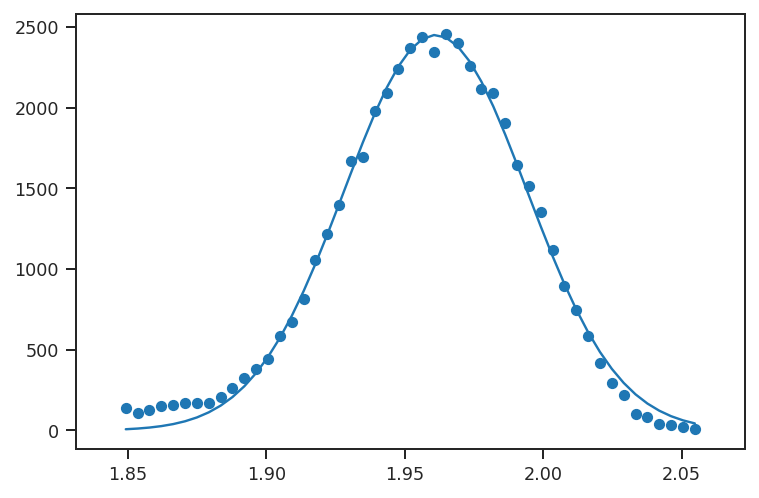

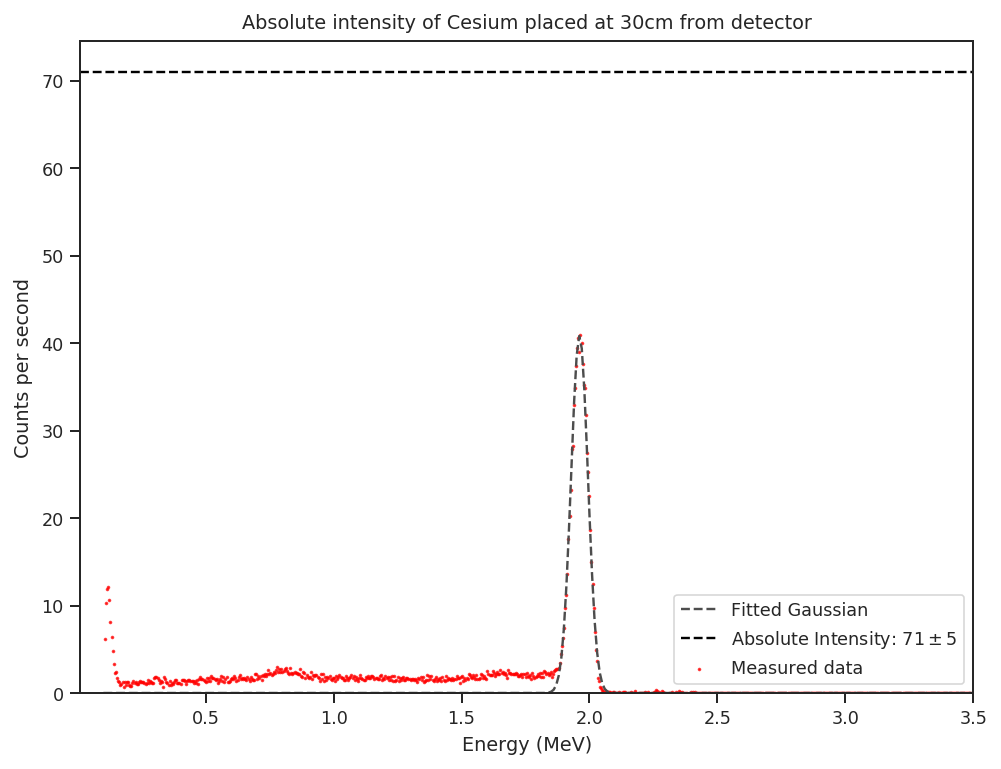

In [58]:
data = from_pha_data("8-8Cs137.csv")

par, cov = fit_sources(data[0][data[4]:data[5]], data[1][data[4]:data[5]])
xs = np.arange(0.1, 4, .01)

plt.figure(figsize=(8,6))
plt.scatter(data[0], data[1]/60, s=1, color='r', alpha=0.7, label="Measured data")
plt.plot(xs, gauss_model(xs, *par)/60, ls="--", color="0.3", label="Fitted Gaussian")
plt.axhline(71, ls="--", color="black", label=r"Absolute Intensity: $71 \pm 5$")
plt.title("Absolute intensity of Cesium placed at 30cm from detector")
plt.ylabel("Counts per second")
plt.xlabel("Energy (MeV)")
plt.xlim(.01, 3.5)
plt.ylim(0)
plt.legend()

In [53]:
a = 6
d = 30
solid_angle = np.pi*(a/d)**2

def abs_intensity(height, peak):
    solid_angle = np.pi*(a/d)**2
    return (height/60)*(peak/(np.pi*a**2))*4*np.pi/(solid_angle)

def abs_err(h, p, h_err, p_err, Ia):
    err= np.sqrt((h_err/h)**2 + (p_err/p)**2 + 2*(.1/6)**2 + (.1/30))
    return err*Ia

Ia = abs_intensity(*par[:2])
print(par[0]/60, np.sqrt(np.diag(cov)))    
print(Ia, abs_err(*par[:2], *np.sqrt(np.diag(cov))[:2], Ia))

40.822919290886475 [2.26616831e+01 3.52601010e-04 3.53129990e-04]
70.788413654327 4.4627708649143445
